In [1]:
import pylab as plt
import numpy as np
from scipy import optimize, special
import cPickle
from iminuit import Minuit
%matplotlib inline

In [20]:
def get_correlation_length_matrix(size, e1, e2):
    if abs(e1)>1:
        e1 = 0
    if abs(e2)>1:
        e2 = 0
    e = np.sqrt(e1**2 + e2**2)
    q = (1-e) / (1+e)
    phi = 0.5 * np.arctan2(e2,e1)
    rot = np.array([[np.cos(phi), np.sin(phi)],
                    [-np.sin(phi), np.cos(phi)]])
    ell = np.array([[size**2, 0],
                    [0, (size * q)**2]])
    L = np.dot(rot.T, ell.dot(rot))
    return L

def gauss(x, y, sigma,
          corr_length, g1, g2, add_noise=True):
    L = get_correlation_length_matrix(corr_length, g1, g2)
    l = np.linalg.inv(L)
    dist_a = (l[0,0]*x*x) + (2*l[0,1]*x*y) + (l[1,1]*y*y)
    z = np.exp(-0.5 * dist_a)
    if add_noise:
        np.random.seed(42)
        noise = np.random.normal(scale=sigma*0.05, size=np.shape(z))
        z += noise
        return z*sigma**2, np.eye(len(z)) * (sigma*0.05)**2
    else:
        return z*sigma**2

def VK(x, y, sigma,
       corr_length, g1, g2, add_noise=True):
    L = get_correlation_length_matrix(corr_length, g1, g2)
    l = np.linalg.inv(L)
    dist_a = (l[0,0]*x*x) + (2*l[0,1]*x*y) + (l[1,1]*y*y)
    z = np.zeros_like(dist_a)
    Filter = dist_a != 0.
    z[Filter] = dist_a[Filter]**(5./12.) *  special.kv(5./6., 2*np.pi * np.sqrt(dist_a[Filter]))
    lim0 = special.gamma(5./6.) /(2 * ((np.pi)**(5./6.)) )
    if np.sum(Filter) != len(z):
        z[~Filter] = lim0
    z /= lim0
    if add_noise:
        np.random.seed(42)
        noise = np.random.normal(scale=sigma*0.05, size=np.shape(z))
        z += noise
        return z*sigma**2, np.eye(len(z)) * (sigma*0.05)**2
    else:
        return z*sigma**2
    
def model_skl(kernel_class, x, y, sigma, corr_length, g1, g2, add_noise=True):
    L = get_correlation_length_matrix(corr_length, g1, g2)
    invLam = np.linalg.inv(L)
    kernel_used = kernel(invLam=invLam)
    coord = np.array([x, y]).T
    pcf = kernel_used.__call__(coord,Y=np.zeros_like(coord))[:,0]
    if add_noise:
        np.random.seed(42)
        noise = np.random.normal(scale=sigma*0.05, size=np.shape(pcf))
        z += noise
        return pcf*sigma**2, np.eye(len(pcf)) * (sigma*0.05)**2
    else:
        return pcf*sigma**2

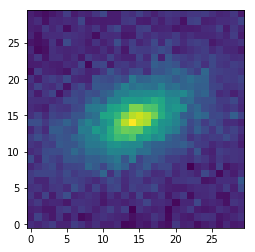

In [21]:
N = 30
x = np.linspace(-5,5,N)
x, y = np.meshgrid(x, x)
x = x.reshape(N**2)
y = y.reshape(N**2)

z, v = VK(x, y, 1., 10., 0.2, 0.2)
z = z.reshape((N,N))

plt.imshow(z, origin='lower')

/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 707.873781938 
 TOTAL NCALL = 98 
 NCALLS = 98 
 
 
 EDM = 5.46808067793e-05 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,24.7003,0,,,,,No
1,x1,-2.30908,0,,,,,No
2,x2,0.27936,0,,,,,No


restart fit because failure


/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 707.87372325 
 TOTAL NCALL = 33 
 NCALLS = 33 
 
 
 EDM = 7.72828982895e-10 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,24.7059,0,,,,,No
1,x1,-2.30908,0,,,,,No
2,x2,0.279291,0,,,,,No


restart fit because failure


/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 707.873723249 
 TOTAL NCALL = 38 
 NCALLS = 38 
 
 
 EDM = 4.53447811105e-12 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,24.7058,0,,,,,No
1,x1,-2.30908,0,,,,,No
2,x2,0.279292,0,,,,,No


restart fit because failure


/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 707.873723249 
 TOTAL NCALL = 27 
 NCALLS = 27 
 
 
 EDM = 1.37363257914e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,24.7058,0,,,,,No
1,x1,-2.30908,0,,,,,No
2,x2,0.279292,0,,,,,No


restart fit because failure


/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 707.873723249 
 TOTAL NCALL = 27 
 NCALLS = 27 
 
 
 EDM = 1.37363257914e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,24.7058,0,,,,,No
1,x1,-2.30908,0,,,,,No
2,x2,0.279292,0,,,,,No


restart fit because failure


/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 707.873723249 
 TOTAL NCALL = 27 
 NCALLS = 27 
 
 
 EDM = 1.37363257914e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,24.7058,0,,,,,No
1,x1,-2.30908,0,,,,,No
2,x2,0.279292,0,,,,,No


restart fit because failure


/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 707.873723249 
 TOTAL NCALL = 27 
 NCALLS = 27 
 
 
 EDM = 1.37363257914e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,24.7058,0,,,,,No
1,x1,-2.30908,0,,,,,No
2,x2,0.279292,0,,,,,No


restart fit because failure


/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 707.873723249 
 TOTAL NCALL = 27 
 NCALLS = 27 
 
 
 EDM = 1.37363257914e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,24.7058,0,,,,,No
1,x1,-2.30908,0,,,,,No
2,x2,0.279292,0,,,,,No


restart fit because failure


/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 707.873723249 
 TOTAL NCALL = 27 
 NCALLS = 27 
 
 
 EDM = 1.37363257914e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,24.7058,0,,,,,No
1,x1,-2.30908,0,,,,,No
2,x2,0.279292,0,,,,,No


restart fit because failure


/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 707.873723249 
 TOTAL NCALL = 27 
 NCALLS = 27 
 
 
 EDM = 1.37363257914e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,24.7058,0,,,,,No
1,x1,-2.30908,0,,,,,No
2,x2,0.279292,0,,,,,No


restart fit because failure


/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 707.873723249 
 TOTAL NCALL = 27 
 NCALLS = 27 
 
 
 EDM = 1.37363257914e-14 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 False 
 True 
 False 
 False 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 True 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,24.7058,0,,,,,No
1,x1,-2.30908,0,,,,,No
2,x2,0.279292,0,,,,,No


[0.5010018663633271, 24.70584258059063, -2.3090790814635, 0.2792915943083217, -3.0040275926445936]


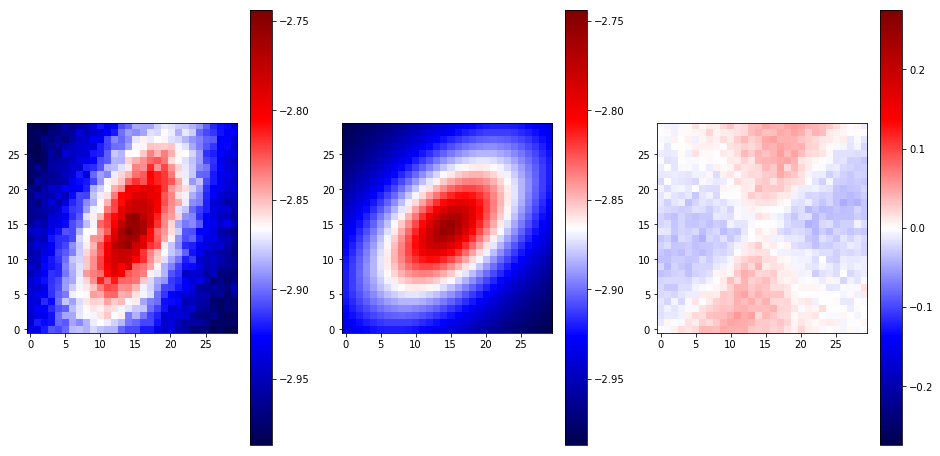

In [90]:
def get_correlation_length_matrix(size, e1, e2):
    if abs(e1)>1:
        e1 = 0
    if abs(e2)>1:
        e2 = 0
    e = np.sqrt(e1**2 + e2**2)
    q = (1-e) / (1+e)
    phi = 0.5 * np.arctan2(e2,e1)
    rot = np.array([[np.cos(phi), np.sin(phi)],
                    [-np.sin(phi), np.cos(phi)]])
    ell = np.array([[size**2, 0],
                    [0, (size * q)**2]])
    L = np.dot(rot.T, ell.dot(rot))
    return L


def get_kernel_class(A):

    if A.__class__ in [treegp.kernels.AnisotropicVonKarman, 
                       treegp.kernels.AnisotropicRBF,
                       sklearn.gaussian_process.kernels.Product]:

        if A.__class__ in [sklearn.gaussian_process.kernels.Product]:
            ok = False
            for key in A.__dict__:
                if A.__dict__[key].__class__ in [treegp.kernels.AnisotropicVonKarman,
                                                 treegp.kernels.AnisotropicRBF]:
                    kernel_class = A.__dict__[key].__class__
                    ok = True
            if not ok:
                raise ValueError('Work only with treegp.kernels.AnisotropicVonKarman and treegp.kernels.AnisotropicRBF')
        else:
            kernel_class = A.__class__
        return kernel_class
    else:
        raise ValueError('Work only with treegp.kernels.AnisotropicVonKarman and treegp.kernels.AnisotropicRBF')

class robust_2dfit(object):
    
    def __init__(self, kernel, flat_data, x, y, W, mask=None):
        
        if mask is None:
            self.mask = np.array([True]*len(x))
        else:
            self.mask = mask

        self.kernel_class = get_kernel_class(kernel)
        self.flat_data = flat_data
        self.x = x
        self.y = y
        self.coord = np.array([x, y]).T
        self.W = W
        self.N = int(np.sqrt(len(self.x)))
        
    def _model_skl(self, sigma, corr_length, g1, g2):

        L = get_correlation_length_matrix(corr_length, g1, g2)
        invLam = np.linalg.inv(L)
        kernel_used = self.kernel_class(invLam=invLam)
        pcf = kernel_used.__call__(self.coord,Y=np.zeros_like(self.coord))[:,0]
        self.kernel_fit = kernel_used
        return pcf * sigma**2
        
    def chi2(self, param):
        model = self._model_skl(1., param[0], 
                                param[1], param[2])
        model = model[self.mask]
        F = np.array([model, np.ones_like(model)]).T
        FWF = np.dot(F.T, self.W).dot(F)
        Y = self.flat_data[self.mask].reshape((len(model), 1))
        self.alpha = np.linalg.inv(FWF).dot(np.dot(F.T, self.W).dot(Y))
        self.residuals = self.flat_data[self.mask] - ((self.alpha[0] * model) + self.alpha[1])
        self.chi2_value = self.residuals.dot(self.W).dot(self.residuals.reshape((len(model), 1)))
        return self.chi2_value

    def _minimize_minuit(self, p0 = [3000., 0.2, 0.2]):
        
        self.m = Minuit.from_array_func(self.chi2, p0)
        self.m.migrad()
        results = [self.m.values[key] for key in self.m.values.keys()]
        self._minuit_result = results
        self.result = [np.sqrt(self.alpha[0][0]), results[0],
                       results[1], results[2],
                       self.alpha[1][0]]
        chi2 = self.chi2(self.result)
        self.kernel_fit = self.alpha[0][0] * self.kernel_fit
        
    def minimize_minuit(self, p0 = [3000., 0.2, 0.2]):
    
        self._minimize_minuit(p0=p0)
        
        if not self.m.migrad_ok():
            for i in range(10):
                print "restart fit because failure"
                self._minimize_minuit(p0=self._minuit_result)
                if self.m.migrad_ok():
                    break
        
    def plot_result(self):
        CMAP = plt.cm.seismic
        MAX = np.max(self.flat_data)
        MIN = np.min(self.flat_data)
        print self.result
        plt.figure(figsize=(16,8))
        plt.subplot(1,3,1)
        plt.imshow(self.flat_data.reshape((self.N,self.N)), 
                   origin="lower", vmin=MIN, 
                   vmax=MAX, cmap=CMAP)
        plt.colorbar()
        
        plt.subplot(1,3,2)
        predict = self._model_skl(self.result[0], self.result[1], 
                                  self.result[2], self.result[3]) + self.result[4]
        plt.imshow(predict.reshape((self.N,self.N)), 
                   origin="lower", vmin=MIN, 
                   vmax=MAX, cmap=CMAP)
        plt.colorbar()
        
        plt.subplot(1,3,3)
        residuals = self.flat_data - predict
        plt.imshow(residuals.reshape((self.N,self.N)), 
                   origin="lower", vmin=-MAX/10., 
                   vmax=MAX/10., cmap=CMAP)
        plt.colorbar()

N = 30
x = np.linspace(-5,5,N)
x, y = np.meshgrid(x, x)
x = x.reshape(N**2)
y = y.reshape(N**2)

z, v = VK(x, y, 0.5, 30., -0.3, 0.3)
z -= 3
w = np.linalg.inv(v)

A = eval_kernel("2 * AnisotropicVonKarman(invLam=np.array([[1., 0], [0., 1.]]))")

fg = robust_2dfit(A, z, x, y, w)
#fg.minimize(p0 = [0.2, -0., -0.])
fg.minimize_minuit(p0 = [5., 0.2, 0.2])
fg.plot_result()

In [68]:
dic = cPickle.load(open('../../astrometry/17946_z/gp_output_17946.pkl'))

/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x0 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x1 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: Parameter x2 is floating but does not have initial step size. Assume 1.
/Users/leget/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:78: InitialParamWarning: errordef is not given. Default to 1.


FCN = 602.530561876 
 TOTAL NCALL = 70 
 NCALLS = 70 
 
 
 EDM = 4.63393481413e-06 
 GOAL EDM = 1e-05 
 
 UP = 1.0 
 
 
 
 
 Valid 
 Valid Param 
 Accurate Covar 
 PosDef 
 Made PosDef 
 
 
 True 
 True 
 True 
 True 
 False 
 
 
 Hesse Fail 
 HasCov 
 Above EDM 
 
 Reach calllim 
 
 
 False 
 True 
 False 
 
 False

+,Name,Value,Hesse Error,Minos Error-,Minos Error+,Limit-,Limit+,Fixed?
0,x0,670.323,15.0166,,,,,No
1,x1,0.348804,0.0134246,,,,,No
2,x2,0.0377424,0.0130129,,,,,No


[1.960599631137292, 670.3229734057842, 0.3488042769390936, 0.037742369045650107, -0.46231913937164604]


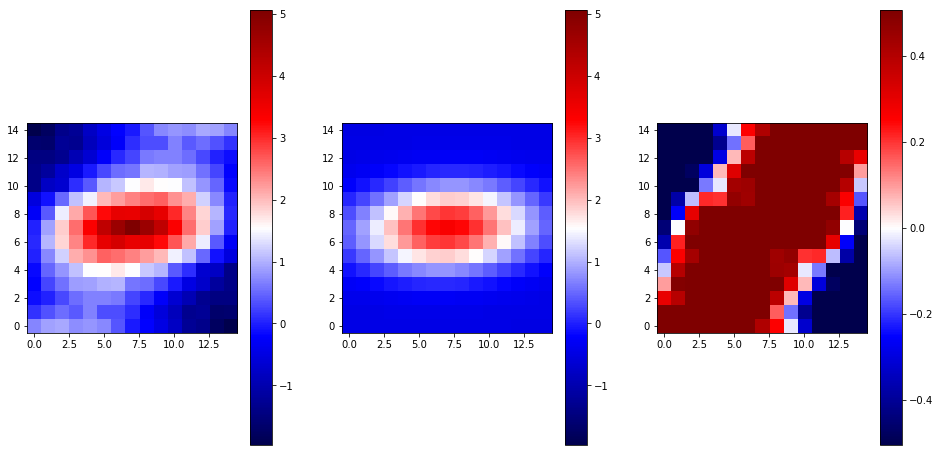

In [81]:
z = dic['gp_output']['gpv.2pcf']
x = dic['gp_output']['gpv.2pcf_dist'][:,0]
y = dic['gp_output']['gpv.2pcf_dist'][:,1]
w = dic['gp_output']['gpv.2pcf_weight']
mask = dic['gp_output']['gpu.2pcf_mask']

A = eval_kernel("2 * AnisotropicRBF(invLam=np.array([[1., 0], [0., 1.]]))")
#fg = fit_gauss(x, y, z, w, mask=mask)
fg = robust_2dfit(A, z, x, y, w, mask=mask)
fg.minimize_minuit(p0 = [600., 0.2, 0.2])
fg.plot_result()
#fg.m.migrad_ok()

In [7]:
from treegp import eval_kernel
import treegp
import sklearn

In [46]:
A = eval_kernel("2 * RBF(1.)")

def get_kernel_class(A):

    if A.__class__ in [treegp.kernels.AnisotropicVonKarman, 
                       treegp.kernels.AnisotropicRBF,
                       sklearn.gaussian_process.kernels.Product]:

        if A.__class__ in [sklearn.gaussian_process.kernels.Product]:
            ok = False
            for key in A.__dict__:
                if A.__dict__[key].__class__ in [treegp.kernels.AnisotropicVonKarman,
                                                 treegp.kernels.AnisotropicRBF]:
                    kernel_class = A.__dict__[key].__class__
                    ok = True
            if not ok:
                raise ValueError('Work only with treegp.kernels.AnisotropicVonKarman and treegp.kernels.AnisotropicRBF')
        else:
            kernel_class = A.__class__
        return kernel_class
    else:
        raise ValueError('Work only with treegp.kernels.AnisotropicVonKarman and treegp.kernels.AnisotropicRBF')
        
print get_kernel_class(A)

ValueError: Work only with treegp.kernels.AnisotropicVonKarman and treegp.kernels.AnisotropicRBF

In [34]:
A = eval_kernel("2 * AnisotropicVonKarman(invLam=np.array([[1., 0], [0., 1.]])) + 2.")
A.__class__

sklearn.gaussian_process.kernels.Sum

In [14]:
used_kernel

AnisotropicVonKarman(invLam=array([[1., 0.],
       [0., 1.]]))

In [56]:
fg.m.migrad_ok()

True

In [63]:
p0 = [3000., 0.2, 0.2] 


In [64]:
p0s[:,0]

array([2.7e+03, 1.8e-01, 1.8e-01])